# 1. 실험환경 Set up

In [1]:
import os
import re
import random
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [180,180]

TRAIN_PATH = os.getenv('HOME')+'/aiffel/chest_xray/data/train/*/*'
VAL_PATH = os.getenv('HOME')+'/aiffel/chest_xray/data/val/*/*'
TEST_PATH = os.getenv('HOME')+'/aiffel/chest_xray/data/test/*/*'


In [35]:
BATCH_SIZE = 12
EPOCHS = 30

# 2. 데이터 준비

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(f"Normal images count in training set : {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f"Pneumonia images count in training set : {COUNT_PNEUMONIA}")

Normal images count in training set : 1070
Pneumonia images count in training set : 3115


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'   #폐렴이면 True, 정상이면 False

In [9]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)  #라벨 검출
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [12]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우 반전
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

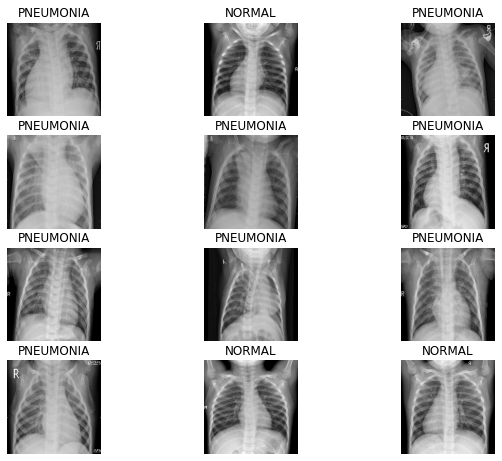

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [22]:
# Convolution 블럭 생성
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense 블럭 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def dense_block_without_batch_norm(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def dense_block_without_dropout(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization()
    ])
    
    return block

In [29]:
# model without batch normalization
def build_model_without_batch_norm():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_without_dropout(512),
        dense_block_without_dropout(128),
        dense_block_without_dropout(64),
        
        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])
    
    return model

In [30]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

In [24]:
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0 : weight_for_0, 1 : weight_for_1}

print('Weight for Normal : {:.2f}'.format(weight_for_0))
print('Weight for Pneumonia : {:.2f}'.format(weight_for_1))

Weight for Normal : 1.96
Weight for Pneumonia : 0.67


# 6. 모델 훈련

In [31]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall')
              ]
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [36]:
with tf.device('/GPU:0'):
    history = model.fit(train_ds,
                       steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
                       epochs = EPOCHS,
                       validation_data = val_ds,
                       validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
                       class_weight = class_weight
                       )

Epoch 1/30
348/348 [==============================] - 69s 173ms/step - loss: 0.1321 - accuracy: 0.9471 - precision: 0.9885 - recall: 0.9398 - val_loss: 0.1699 - val_accuracy: 0.9176 - val_precision: 0.9928 - val_recall: 0.8943
Epoch 2/30
348/348 [==============================] - 60s 172ms/step - loss: 0.1169 - accuracy: 0.9595 - precision: 0.9903 - recall: 0.9550 - val_loss: 0.0695 - val_accuracy: 0.9732 - val_precision: 0.9960 - val_recall: 0.9674
Epoch 3/30
348/348 [==============================] - 60s 172ms/step - loss: 0.1045 - accuracy: 0.9569 - precision: 0.9903 - recall: 0.9514 - val_loss: 0.0608 - val_accuracy: 0.9751 - val_precision: 0.9894 - val_recall: 0.9765
Epoch 4/30
348/348 [==============================] - 61s 174ms/step - loss: 0.0969 - accuracy: 0.9679 - precision: 0.9917 - recall: 0.9649 - val_loss: 0.0565 - val_accuracy: 0.9799 - val_precision: 0.9831 - val_recall: 0.9895
Epoch 5/30
348/348 [==============================] - 61s 176ms/step - loss: 0.0952 - accura

# 7. 결과 확인 및 시각화

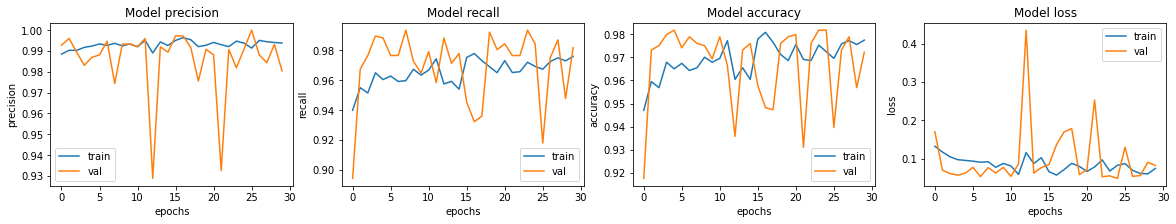

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [38]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

52/52 [==============================] - 6s 108ms/step - loss: 1.8611 - accuracy: 0.7885 - precision: 0.7520 - recall: 0.9872
Loss: 1.8610984086990356,
Accuracy: 0.7884615659713745,
Precision: 0.751953125,
Recall: 0.9871794581413269
